# Multilayer Perceptron for Financial Forecasting

A comprehensive analysis using polynomial detrending, seasonal differencing, and neural networks for time series prediction.

In [15]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

excel_file = 'M3C.xls'
sheet_name = "M3Month"
category = "FINANCE"

In [16]:
data = pd.read_excel(excel_file, sheet_name=sheet_name)
print("Loaded {}".format(sheet_name))

Loaded M3Month


In [17]:
# Start from the 7th column (index 6) 
category_data = data[data['Category'].str.strip() == category]
series = category_data.iloc[0, 6:].dropna().astype(float)  

2. Here we take the first monthly timeseries in the category of finance. We plot it alongside its 2nd degree polynomial trend.

Selected series length: 143 time points


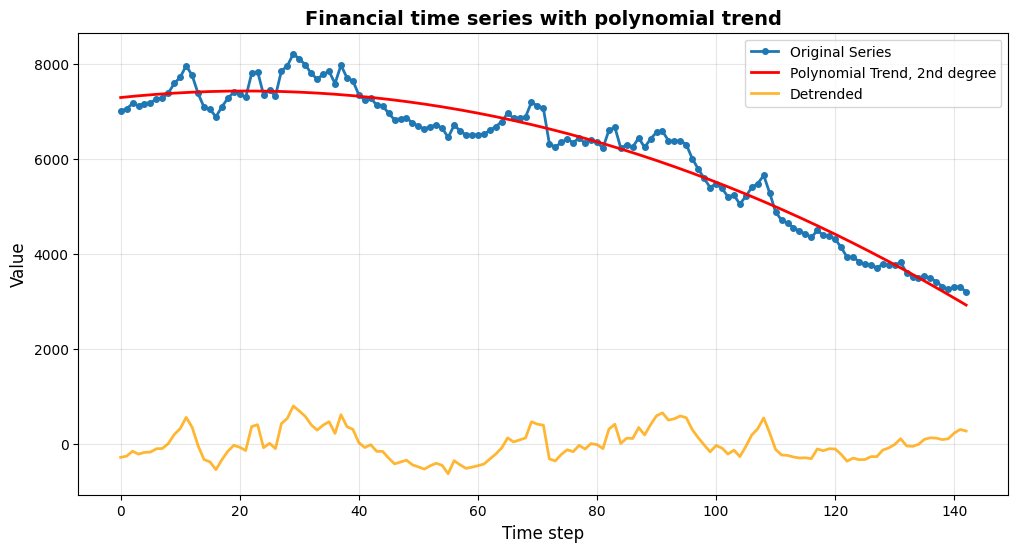

In [18]:
# One times series with polynomial trend
print(f"Selected series length: {len(series)} time points")
poly = PolynomialFeatures(degree=2)
X = np.arange(len(series)).reshape(-1, 1)
y = series.values

x_poly = poly.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(x_poly, y)
poly_trend = poly_model.predict(x_poly)
de_trended = y - poly_trend


plt.figure(figsize=(12, 6))
plt.plot(series.values, marker='o', linewidth=2, markersize=4, label='Original Series')
plt.plot(poly_trend, color='red', linewidth=2, label='Polynomial Trend, 2nd degree')
plt.plot(range(len(de_trended)), de_trended, 'orange', linewidth=2, label='Detrended', alpha=0.8)

plt.title("Financial time series with polynomial trend", fontsize=14, fontweight='bold')
plt.legend()
plt.xlabel("Time step", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

3. Next up is de-trending and de-seasonalizing the timeseries to prepare the input for the MLP

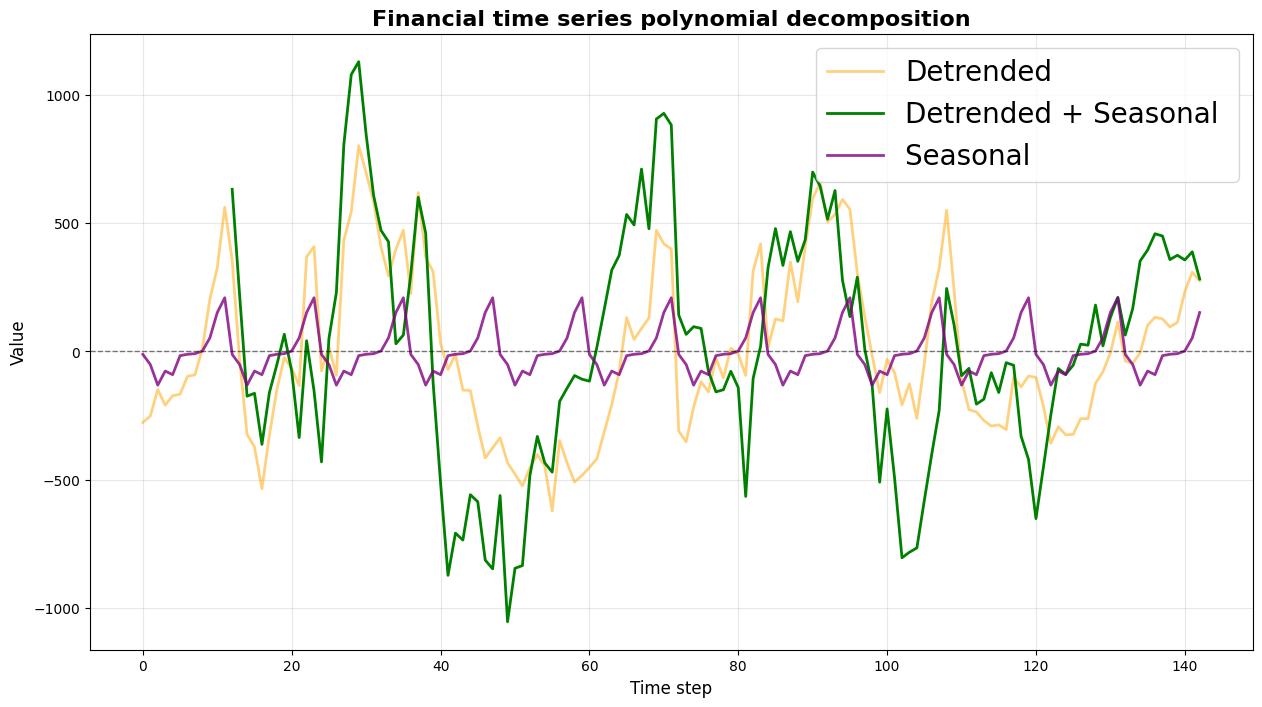

In [19]:

de_trended = y - poly_trend

seasonal_component = np.zeros(len(de_trended))
months_in_year = 12
seasonal_diff = list()

for i in range(months_in_year, len(de_trended)):
    value = de_trended[i] - de_trended[i - months_in_year]
    seasonal_diff.append(value)

# Seasonal component calculation
for m in range(months_in_year):
    month_indices = np.arange(m, len(de_trended), months_in_year)
    month_mean = np.mean(de_trended[month_indices])
    seasonal_component[month_indices] = month_mean



# Combined plot
plt.figure(figsize=(15, 8))
#plt.plot(range(len(y)), y, 'b-', linewidth=2, label='Original', alpha=0.8) # original series
plt.plot(range(len(de_trended)), de_trended, 'orange', linewidth=2, label='Detrended', alpha=0.5) # detrended series
plt.plot(range(months_in_year, len(de_trended)), seasonal_diff, 'green', linewidth=2, label='Detrended + Seasonal ') # detrended + seasonal differenced series
plt.plot(range(len(seasonal_component)), seasonal_component, 'purple', linewidth=2, label='Seasonal ', alpha=0.8) # seasonal component

plt.title("Financial time series polynomial decomposition", fontsize=16, fontweight='bold')
plt.xlabel("Time step", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
plt.legend(fontsize=20)  
plt.show()



4. The data is scaled before being used as input. We also save the last 12 months of the timeseries to use for validation of our model

In [20]:
from sklearn.preprocessing import StandardScaler

# Split BEFORE scaling
seasonal_diff_array = np.array(seasonal_diff)
train_portion = seasonal_diff_array[:-12]  # All except last 12
validation_portion = seasonal_diff_array[-12:]  # Last 12

# Fit scaler ONLY on training data
scaler = StandardScaler()
scaler.fit(train_portion.reshape(-1, 1))

# Transform both using the same scaler
training_data = scaler.transform(train_portion.reshape(-1, 1)).flatten()
validation_data = scaler.transform(validation_portion.reshape(-1, 1)).flatten()    

# Function to create sequences with unequally spaced lags
# Using seasonality-aligned spacing: [1, 3, 6, 12] months back
def create_sequences(data, lags=[1, 3, 6, 12]):
    """
    Create sequences using specific time lags instead of consecutive values.
    
    Args:
        data: Time series data
        lags: List of lag values (e.g., [1, 3, 6, 12] means t-1, t-3, t-6, t-12)
              Aligned with financial cycles: recent, quarterly, semi-annual, annual
    
    Returns:
        X: Input features with shape (n_samples, len(lags))
        y: Target values
    """
    X, y = [], []
    max_lag = max(lags)
    
    # Start from max_lag to ensure we have all required historical values
    for i in range(max_lag, len(data)):
        # Extract values at specific lag positions
        sequence = [data[i - lag] for lag in lags]
        X.append(sequence)
        y.append(data[i])
    
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(training_data, lags=[1, 3, 6, 12])

print(f"Training data length: {len(training_data)}")
print(f"X_train shape: {X_train.shape}")
print(f"Using lags: [1, 3, 6, 12] months (4 input features)")
print(f"Lag interpretation: recent(1), quarterly(3), semi-annual(6), annual(12)")
print(f"Training Mean: {training_data.mean():.18f}, Training Std: {training_data.std():.6f}")



Training data length: 119
X_train shape: (107, 4)
Using lags: [1, 3, 6, 12] months (4 input features)
Lag interpretation: recent(1), quarterly(3), semi-annual(6), annual(12)
Training Mean: 0.000000000000000019, Training Std: 1.000000


5. Class for the multilayer perceptron

In [ ]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.005, l2_lambda=0.0):
        # Better weight initialization (He initialization for tanh)
        self.weight_hidden = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.weight_output = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.bias_hidden = np.zeros((1, hidden_size))
        self.bias_output = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda  # L2 regularization strength
        self.losses = []

    # In our implementation we chose the tanh activation function for the hidden layer
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1.0 - np.tanh(x) ** 2

    def forward(self, X):
        # Hidden layer with tanh activation function
        self.hidden_input = X @ self.weight_hidden + self.bias_hidden
        self.hidden_output = self.tanh(self.hidden_input)
        
        # No activation function for the output, since we are doing regression
        self.final_input = self.hidden_output @ self.weight_output + self.bias_output
        self.final_output = self.final_input  
        
        return self.final_output
    
    def backward(self, X, y, output):
        m = X.shape[0]  # sample size
        
        # reshape to match output shape
        y = y.reshape(-1, 1)
        
        output_error = output - y  
        
        # Hidden layer gradient
        hidden_error = np.dot(output_error, self.weight_output.T) * self.tanh_derivative(self.hidden_input)
        
        # weights and bias update with L2 regularization
        # L2 regularization: add (lambda/m) * weights to gradient
        self.weight_output -= self.learning_rate * (np.dot(self.hidden_output.T, output_error) / m + (self.l2_lambda / m) * self.weight_output)
        self.bias_output -= self.learning_rate * np.sum(output_error, axis=0, keepdims=True) / m
        self.weight_hidden -= self.learning_rate * (np.dot(X.T, hidden_error) / m + (self.l2_lambda / m) * self.weight_hidden)
        self.bias_hidden -= self.learning_rate * np.sum(hidden_error, axis=0, keepdims=True) / m

    def train(self, X, y, epochs, patience=None, min_delta=1e-6):
   
        best_loss = float('inf')
        patience_counter = 0
        best_weights = None
        
        for epoch in tqdm(range(epochs), desc="Training progress"):
            # Forward pass
            output = self.forward(X)
            
            # Backward pass
            self.backward(X, y, output)
            
            # MSE
            loss = np.mean((output - y.reshape(-1, 1)) ** 2)
            
            # Add L2 regularization term to loss for monitoring (not used in backprop)
            if self.l2_lambda > 0:
                l2_penalty = (self.l2_lambda / (2 * m)) * (np.sum(self.weight_hidden ** 2) + np.sum(self.weight_output ** 2))
                total_loss = loss + l2_penalty
                self.losses.append(total_loss)
            else:
                self.losses.append(loss)

            # Early stopping to avoid unnecessary training
            if patience is not None:
                if loss < best_loss - min_delta:
                    best_loss = loss
                    patience_counter = 0
                    # Save best weights
                    best_weights = {
                        'weight_hidden': self.weight_hidden.copy(),
                        'weight_output': self.weight_output.copy(),
                        'bias_hidden': self.bias_hidden.copy(),
                        'bias_output': self.bias_output.copy()
                    }
                else:
                    patience_counter += 1
                
                # Stop if patience exceeded
                if patience_counter >= patience:
                    tqdm.write(f"\n Early stopping at epoch {epoch+1}")
                    tqdm.write(f"Best loss: {best_loss:.6f}")
                    # Restore best weights
                    if best_weights:
                        self.weight_hidden = best_weights['weight_hidden']
                        self.weight_output = best_weights['weight_output']
                        self.bias_hidden = best_weights['bias_hidden']
                        self.bias_output = best_weights['bias_output']
                    break
            
            # Progress updates
            if (epoch + 1) % 100000 == 0:
                if patience is not None:
                    tqdm.write(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}, Best: {best_loss:.6f}, Patience: {patience_counter}/{patience}")
                else:
                    tqdm.write(f"Epoch {epoch+1}/{epochs}, Loss (MSE): {loss:.6f}")

        tqdm.write(f"Final loss: {loss:.10f}")
        
    def predict(self, X):
        output = self.forward(X)
        return output.flatten()
    


6. Train model on the pre-processed data

In [22]:
model = MLP(input_size=4, hidden_size=5, output_size=1, learning_rate=5e-4)
model.train(X_train, y_train, epochs=500000, patience=100000, min_delta=1e-6)
def forecast_multiple_steps_tf(model, last_sequence, n_steps=12):

    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_steps):
        current_sequence_reshaped = current_sequence.reshape((1, -1))
        next_value = model.predict(current_sequence_reshaped)
        predictions.append(next_value[0, 0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_value  # Append the predicted value
    
    return np.array(predictions)  



Training progress:   3%|▎         | 17341/500000 [00:01<00:26, 18010.04it/s]

Training progress:  21%|██        | 103584/500000 [00:05<00:21, 18337.94it/s]

Epoch 100000/500000, Loss: 0.209884, Best: 0.209885, Patience: 2/100000


Training progress:  40%|████      | 201775/500000 [00:11<00:16, 18298.07it/s]

Epoch 200000/500000, Loss: 0.182846, Best: 0.182846, Patience: 1/100000


Training progress:  61%|██████    | 303646/500000 [00:16<00:10, 18834.04it/s]

Epoch 300000/500000, Loss: 0.161217, Best: 0.161218, Patience: 5/100000


Training progress:  81%|████████  | 402987/500000 [00:21<00:05, 17766.73it/s]

Epoch 400000/500000, Loss: 0.150850, Best: 0.150850, Patience: 0/100000


Training progress: 100%|██████████| 500000/500000 [00:27<00:00, 18376.84it/s]

Epoch 500000/500000, Loss: 0.142824, Best: 0.142825, Patience: 9/100000
Final loss: 0.1428244245


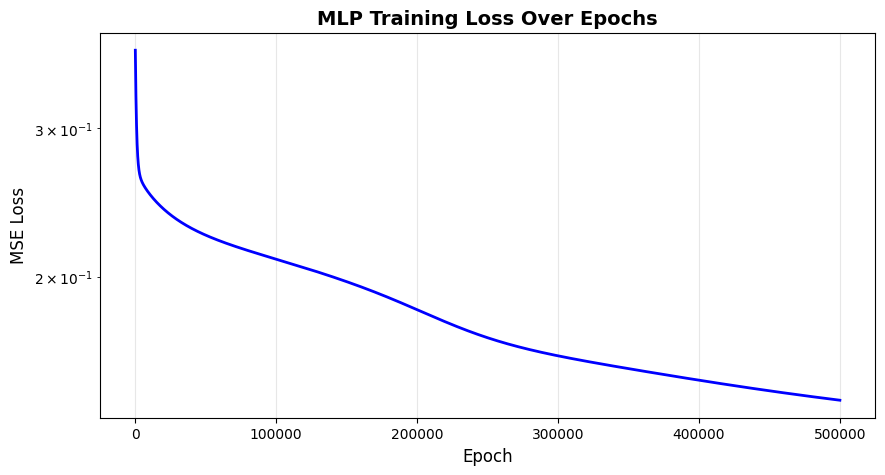

Initial Loss: 0.371259
Final Loss: 0.1428244245
Loss Reduction: 61.529729286741%


In [23]:
# Trainining loss plot
plt.figure(figsize=(10, 5))
plt.plot(model.losses, linewidth=2, color='blue')
plt.title('MLP Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.yscale('log')  
plt.show()

print(f"Initial Loss: {model.losses[0]:.6f}")
print(f"Final Loss: {model.losses[-1]:.10f}")
print(f"Loss Reduction: {((model.losses[0] - model.losses[-1]) / model.losses[0] * 100):.12f}%")

In [ ]:
def forecast_multiple_steps(model, data_history, n_steps=12, lags=[1, 2, 3, 6, 12]):
    predictions = []

    history_buffer = list(data_history[-max(lags):])
    
    for _ in range(n_steps):
        # Extract features at specific lag positions from the end of buffer
        current_features = [history_buffer[-lag] for lag in lags]
        
        # Predict next value
        next_value = model.predict(np.array(current_features).reshape(1, -1))[0]
        predictions.append(next_value)
        
        # Append prediction to history buffer
        history_buffer.append(next_value)
    
    return np.array(predictions)


validation_predictions_scaled = forecast_multiple_steps(model, training_data, n_steps=12, lags=[1, 3, 6, 12])



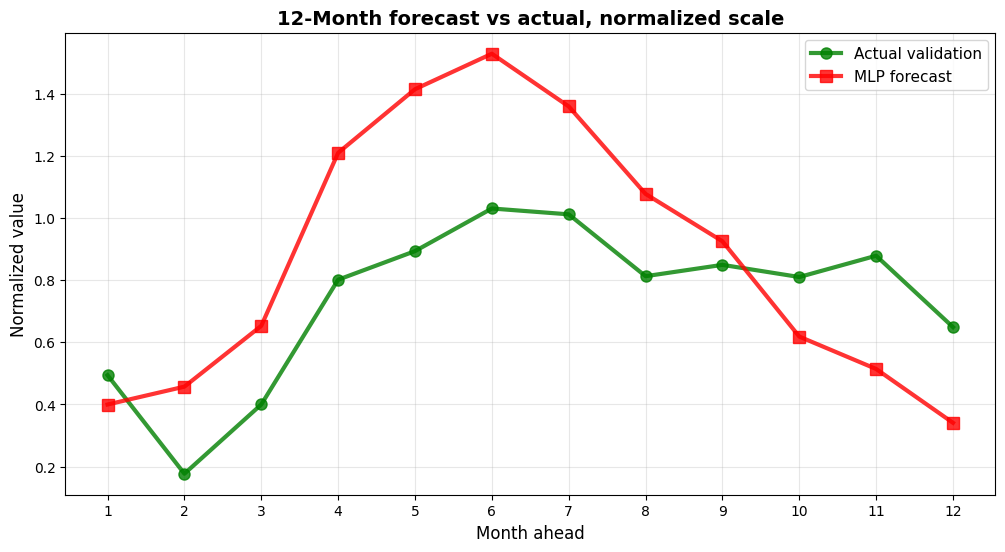


Validation Metrics (Normalized Scale):
MSE: 0.108254
MAE: 0.300638
RMSE: 0.329019


In [25]:
# Plot 3: Validation Predictions vs Actual (Processed Scale)
plt.figure(figsize=(12, 6))
months = np.arange(1, 13)
plt.plot(months, validation_data, 'o-', label='Actual validation', 
         linewidth=3, markersize=8, color='green', alpha=0.8)
plt.plot(months, validation_predictions_scaled, 's-', label='MLP forecast', 
         linewidth=3, markersize=8, color='red', alpha=0.8)
plt.title('12-Month forecast vs actual, normalized scale', fontsize=14, fontweight='bold')
plt.xlabel('Month ahead', fontsize=12)
plt.ylabel('Normalized value', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(months)
plt.show()

# Validation metrics
val_mse = np.mean((validation_predictions_scaled - validation_data) ** 2)
val_mae = np.mean(np.abs(validation_predictions_scaled - validation_data))
val_rmse = np.sqrt(val_mse)
print(f"\nValidation Metrics (Normalized Scale):")
print(f"MSE: {val_mse:.6f}")
print(f"MAE: {val_mae:.6f}")
print(f"RMSE: {val_rmse:.6f}")

In [26]:
# Reverse transformations: Convert predictions back to original scale
print("="*60)
print("REVERSING TRANSFORMATIONS")
print("="*60)

# Step 1: Denormalize predictions
validation_predictions_denorm = scaler.inverse_transform(
    validation_predictions_scaled.reshape(-1, 1)
).flatten()

validation_actual_denorm = scaler.inverse_transform(
    validation_data.reshape(-1, 1)
).flatten()

print("\nStep 1 - Denormalized:")
print(f"Predictions: {validation_predictions_denorm[:3]}...")
print(f"Actual: {validation_actual_denorm[:3]}...")

# Step 2: Reverse seasonal differencing
# We need the detrended values from 12 months before the validation period
reference_values = de_trended[-(24):-12]

# Add back the seasonal component
validation_predictions_deseasoned = validation_predictions_denorm + reference_values
validation_actual_deseasoned = validation_actual_denorm + reference_values

print("\nStep 2 - Reverse seasonal differencing:")
print(f"Predictions: {validation_predictions_deseasoned[:3]}...")
print(f"Actual: {validation_actual_deseasoned[:3]}...")

# Step 3: Add back polynomial trend
# Get trend values for the validation period (last 12 points)
validation_trend = poly_trend[-12:]

validation_predictions_original = validation_predictions_deseasoned + validation_trend
validation_actual_original = validation_actual_deseasoned + validation_trend

print("\nStep 3 - Add back trend:")
print(f"Predictions: {validation_predictions_original[:3]}...")
print(f"Actual: {validation_actual_original[:3]}...")
print(f"\nOriginal validation values from series:")
print(f"Series: {y[-12:][:3]}...")
print("="*60)

REVERSING TRANSFORMATIONS

Step 1 - Denormalized:
Predictions: [167.03855683 193.63396292 284.14792764]...
Actual: [210.68400419  63.97354677 167.06308936]...

Step 2 - Reverse seasonal differencing:
Predictions: [71.07893363 92.46113306 70.47768632]...
Actual: [114.72438099 -37.19928309 -46.60715197]...

Step 3 - Add back trend:
Predictions: [3776.35455264 3729.76041615 3639.18483828]...
Actual: [3820.  3600.1 3522.1]...

Original validation values from series:
Series: [3820.  3600.1 3522.1]...


In [27]:
# Calculate metrics on original scale
original_mse = np.mean((validation_predictions_original - y[-12:]) ** 2)
original_mae = np.mean(np.abs(validation_predictions_original - y[-12:]))
original_rmse = np.sqrt(original_mse)
original_mape = np.mean(np.abs((y[-12:] - validation_predictions_original) / y[-12:])) * 100

print("="*60)
print("FINAL METRICS ON ORIGINAL SCALE")
print("="*60)
print(f"MSE:   {original_mse:.2f}")
print(f"MAE:   {original_mae:.2f}")
print(f"RMSE:  {original_rmse:.2f}")
print(f"MAPE:  {original_mape:.2f}%")
print("="*60)

# Month-by-month comparison
comparison_df = pd.DataFrame({
    'Month': range(1, 13),
    'Actual': y[-12:],
    'Predicted': validation_predictions_original,
    'Error': validation_predictions_original - y[-12:],
    'Abs_Error': np.abs(validation_predictions_original - y[-12:]),
    'Pct_Error': ((validation_predictions_original - y[-12:]) / y[-12:]) * 100
})

print("\nMonth-by-Month Comparison:")
print(comparison_df.to_string(index=False))

FINAL METRICS ON ORIGINAL SCALE
MSE:   23170.33
MAE:   139.09
RMSE:  152.22
MAPE:  4.05%

Month-by-Month Comparison:
 Month  Actual   Predicted       Error  Abs_Error  Pct_Error
     1  3820.0 3776.354553  -43.645447  43.645447  -1.142551
     2  3600.1 3729.760416  129.660416 129.660416   3.601578
     3  3522.1 3639.184838  117.084838 117.084838   3.324291
     4  3493.9 3682.859100  188.959100 188.959100   5.408257
     5  3531.7 3772.786627  241.086627 241.086627   6.826362
     6  3492.7 3723.161180  230.461180 230.461180   6.598367
     7  3414.9 3575.608362  160.708362 160.708362   4.706093
     8  3312.0 3434.515591  122.515591 122.515591   3.699142
     9  3257.2 3292.302663   35.102663  35.102663   1.077694
    10  3304.1 3215.395307  -88.704693  88.704693  -2.684685
    11  3306.9 3138.267884 -168.632116 168.632116  -5.099402
    12  3199.7 3057.211434 -142.488566 142.488566  -4.453185


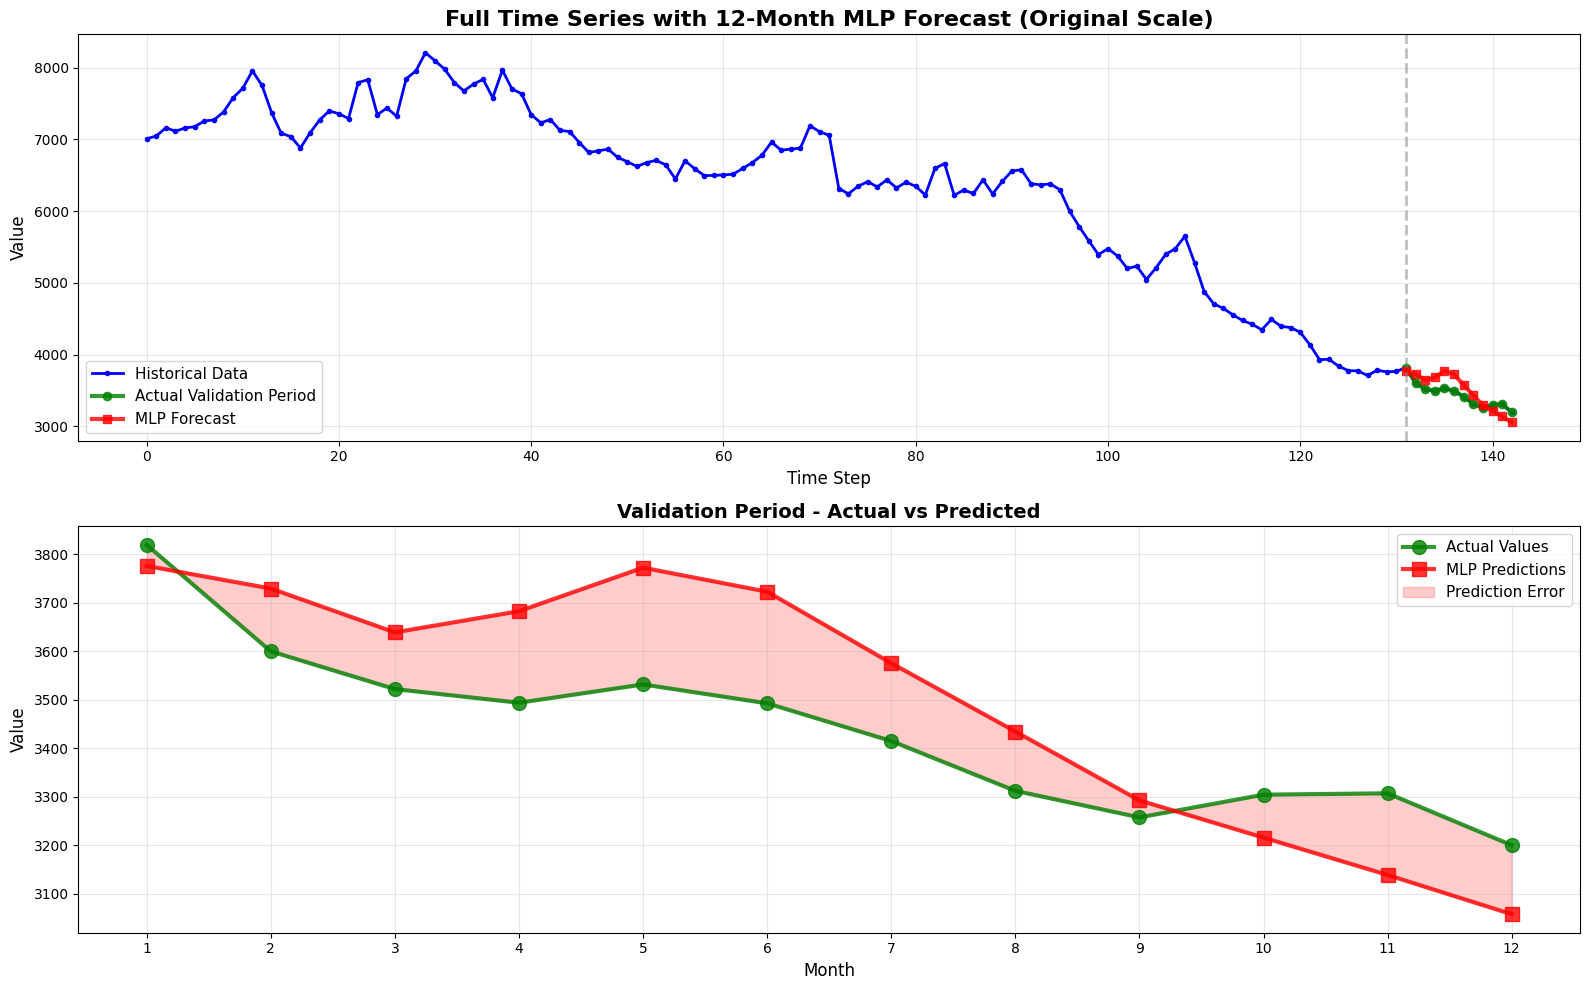

In [28]:
# Plot 4: Full Time Series with Forecast (Original Scale)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Top plot: Full series
ax1.plot(range(len(y)), y, 'b-', linewidth=2, label='Historical Data', marker='o', markersize=3)
ax1.plot(range(len(y) - 12, len(y)), y[-12:], 'go-', linewidth=3, 
         markersize=6, label='Actual Validation Period', alpha=0.8)
ax1.plot(range(len(y) - 12, len(y)), validation_predictions_original, 'rs-', 
         linewidth=3, markersize=6, label='MLP Forecast', alpha=0.8)
ax1.axvline(len(y) - 12, color='gray', linestyle='--', linewidth=2, alpha=0.5)
ax1.set_title('Full Time Series with 12-Month MLP Forecast (Original Scale)', 
              fontsize=16, fontweight='bold')
ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Value', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Bottom plot: Zoomed validation period
months = np.arange(1, 13)
ax2.plot(months, y[-12:], 'go-', linewidth=3, markersize=10, 
         label='Actual Values', alpha=0.8)
ax2.plot(months, validation_predictions_original, 'rs-', linewidth=3, 
         markersize=10, label='MLP Predictions', alpha=0.8)
ax2.fill_between(months, y[-12:], validation_predictions_original, 
                  alpha=0.2, color='red', label='Prediction Error')
ax2.set_title('Validation Period - Actual vs Predicted', fontsize=14, fontweight='bold')
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Value', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(months)

plt.tight_layout()
plt.show()